In [621]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import glob
import cv2

img_dir_path = "/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test"
path = "/home/olle/PycharmProjects/LODE/workspace/feature_statistics/cell_data"

cell_pd = pd.read_csv(os.path.join(path, "feature_statistics.csv"))

cell_pd = cell_pd.drop(columns=["0", "11", "12", "14", "15"])
cell_pd.rename(columns={"13":"11"}, inplace=True)

cell_pd = cell_pd.drop_duplicates(subset=["id"])

In [622]:
# create adata object
var_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]

X = np.array(cell_pd[var_names])

obs_id = cell_pd.id
obs_cls = cell_pd.id.str.split("-", expand=True)[0]


adata = sc.AnnData(X=X)
adata.obs["obs_id"] = obs_id.values.tolist()
adata.obs["obs_cls"] = obs_cls.values.tolist()
adata.var["var_name"] = var_names

adata.obs["img_path"] = img_dir_path + "/" + adata.obs["obs_cls"] + "/" + adata.obs["obs_id"]

naming_map = {"1":"epiretinal membrane", "2":"neurosensory retina", "3":"intraretinal fluid",
              "4":"subretinal fluid", "5":"subretinal hyp. reflect. mat.", "6":"retinal pigment epithelium", 
              "7":"fibrovascular PED", "8":"drusenoid PED", "9":"posterior hyaloid membrane",
              "10":"choroid","11":"fibrosis"}

adata.var.var_name = adata.var.var_name.map(naming_map)

In [623]:
adata.obs.img_path.iloc[0]

'/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test/NORMAL/NORMAL-9053621-1.jpeg'

#### format index

In [624]:
adata.var.index = adata.var.index.astype(int) + 1
adata.var.index = adata.var.index.astype(str)

In [625]:
#### Add train test split to obs

In [626]:
test_image_path = "/home/olle/PycharmProjects/LODE/workspace/feature_statistics/cell_data/OCT2017/test"

test_ids_list = [i.split("/")[-1] for i in glob.glob(test_image_path + "/*/*")]

all_ids = pd.DataFrame(adata.obs["obs_id"])
test_ids = pd.DataFrame(test_ids_list)
test_paths = pd.DataFrame([test_ids_list, glob.glob(test_image_path + "/*/*")]).T

data_split_pd = pd.merge(all_ids, test_ids, left_on="obs_id", right_on=0, how="left")

data_split_pd["split"] = "train"
data_split_pd["split"][~data_split_pd[0].isna()] = "test"

adata.obs["split"] = data_split_pd.split.values.tolist()

### Preprocessing

In [627]:
# Log and norm data

In [628]:
sc.pp.log1p(adata)

In [629]:
# create adata test object
adata_test = adata[adata.obs.split == "test"]

In [630]:
adata_test.obs.img_path.iloc[0]

'/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test/NORMAL/NORMAL-98720-1.jpeg'

In [631]:
##### compte neighbour hood graph

In [641]:
sc.pp.neighbors(adata_test, n_neighbors=30)
sc.tl.umap(adata_test)

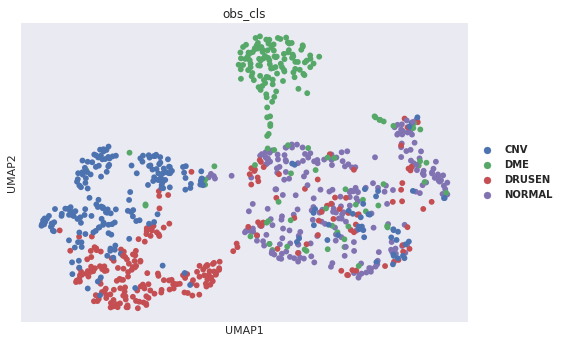

In [642]:
sc.pl.umap(adata_test, color=['obs_cls'])

<Figure size 1440x720 with 0 Axes>

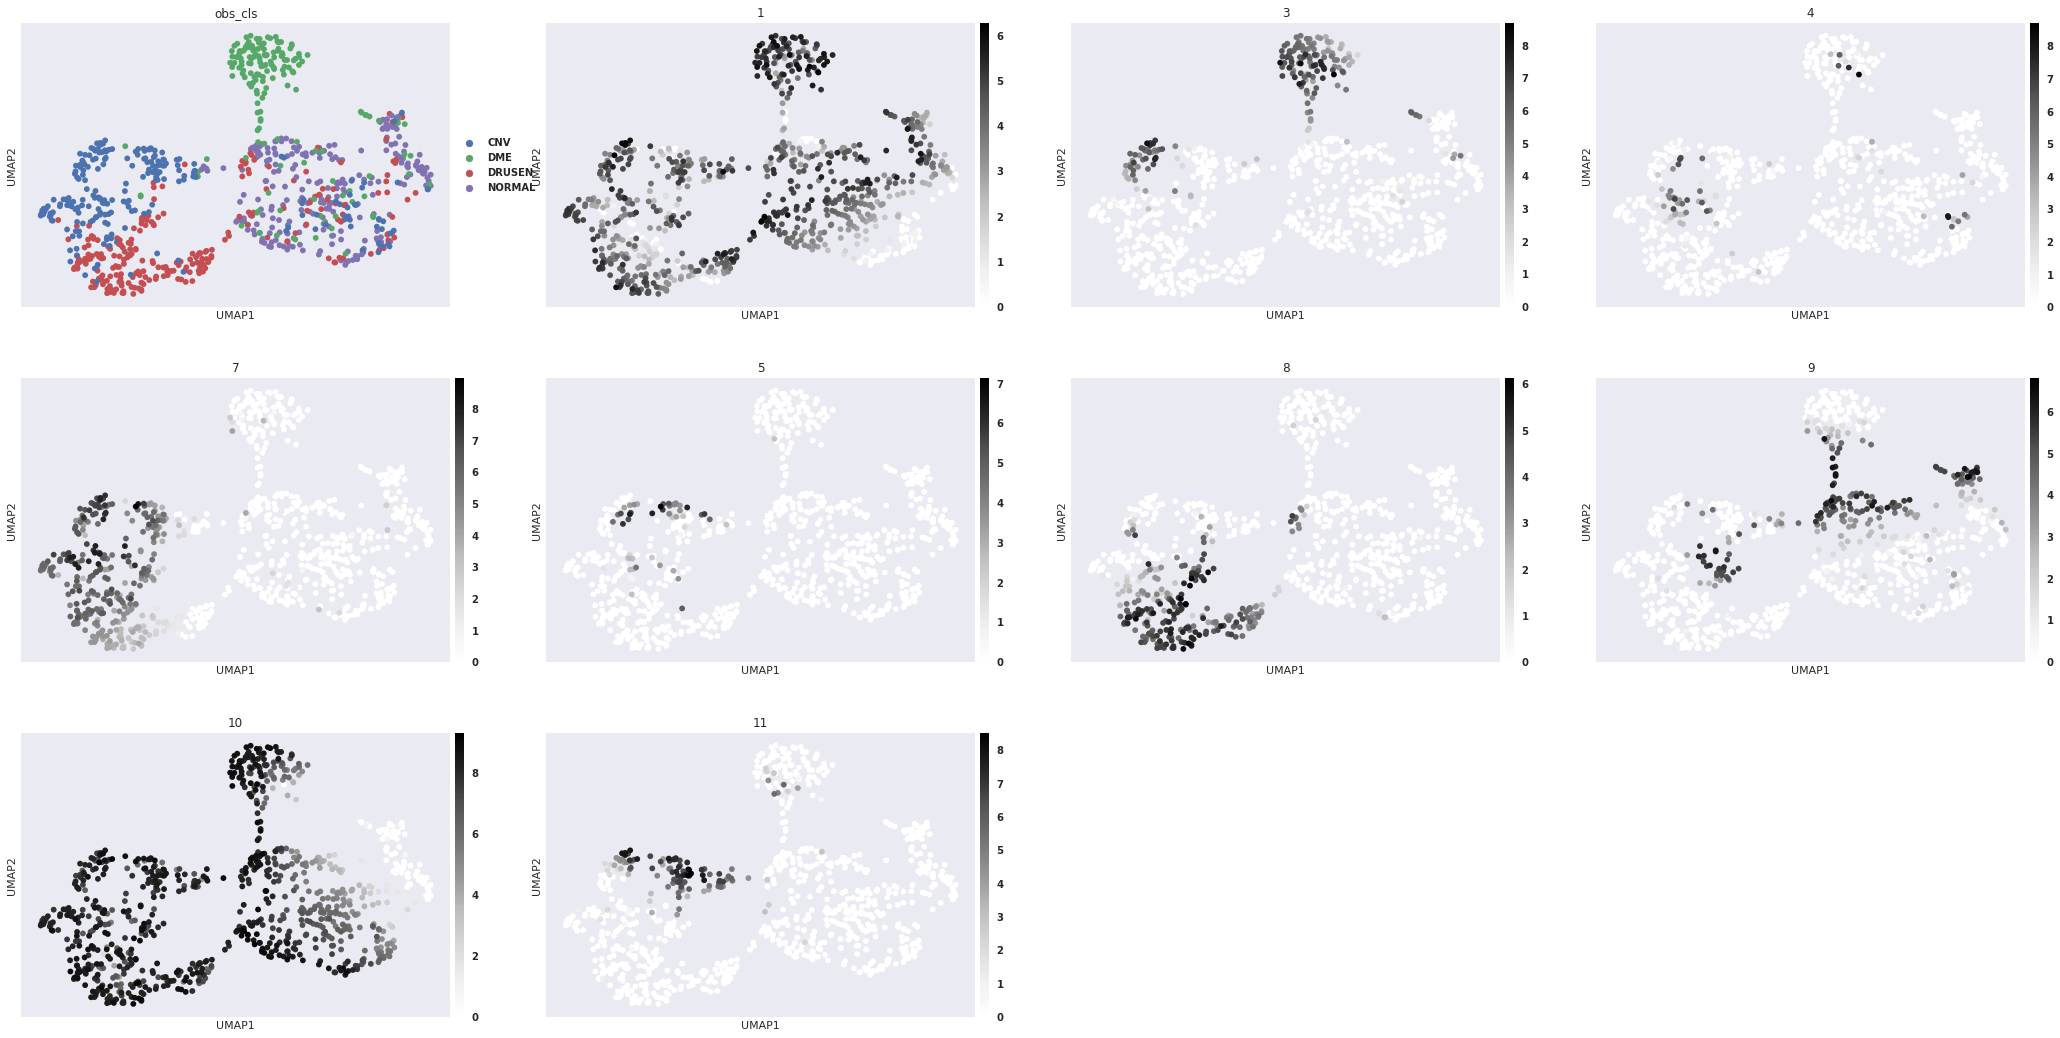

In [643]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_test, color=['obs_cls', "1", "3", "4", "7", "5", "8", "9", "10", "11"])

#### Clustering

In [502]:
sc.tl.leiden(adata_test)
sc.tl.louvain(adata_test)
sc.tl.paga(adata_test)

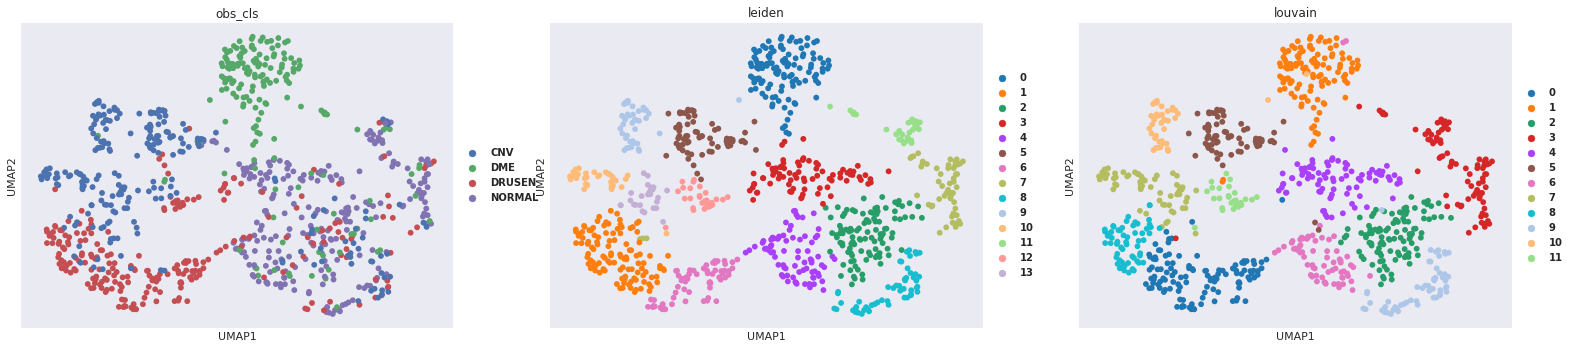

In [503]:
sc.pl.umap(adata_test, color=['obs_cls', "leiden", "louvain"])

In [504]:
#### Feature expression significance

In [527]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

Automatically created module for IPython interactive environment
Automatically created module for IPython interactive environment


In [528]:
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc

def predict_binary_class(data_object, features): 
    available_features = data_object.obs.obs_cls.unique()
    
    allowed_feature = [feature for feature in features if feature in available_features]
    for f in allowed_feature:
        assert f, f"invalid feature, feature must be in {available_features}"
    
    # make copy
    data_copy = deepcopy(data_object)
    
    # extract columns belong to feature
    feature_f = data_copy.obs.obs_cls.isin(features)
    
    # annotate all other to not feature class
    data_copy = data_copy[feature_f]
    X_train = data_copy.X[data_copy.obs.split == "train"]
    y_train = data_copy.obs.obs_cls[data_copy.obs.split == "train"]
    X_test = data_copy.X[data_copy.obs.split == "test"]
    y_test = data_copy.obs.obs_cls[data_copy.obs.split == "test"]
    
    rf = Pipeline([('classifier', RandomForestClassifier(n_estimators=50, random_state=42))])
    
    rf.fit(X_train, y_train)
    
    print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
    print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
    
     
    y_num = y_test.map({features[0]:0, features[1]:1})
    y_num = y_num.astype(np.int32)
        
    fpr, tpr, thresholds = roc_curve(y_num, rf.predict_proba(X_test)[:,0], pos_label=1)
    
    # get feature importance
    feature_importance_result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
    
    fetures_sorted_idx = feature_importance_result.importances_mean.argsort()

    return fpr, tpr, thresholds, feature_importance_result, fetures_sorted_idx, rf

In [529]:
def roc_plot(ax, data1, data2):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    
    area_under_the_curve = auc(data1, data2)
    
    ax.plot(data1, data2, label='ROC curve (area = %0.2f)' % area_under_the_curve)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC-curve: ")
    ax.legend(loc="lower right")
    return ax

def feature_importance_plot(ax, result, sorted_idx):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=adata.var.var_name[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("feature importance")
    
    return ax
    

In [530]:
adata.obs.img_path.iloc[0]

'/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test/NORMAL/NORMAL-9053621-1.jpeg'

RF train accuracy: 1.000
RF test accuracy: 0.939


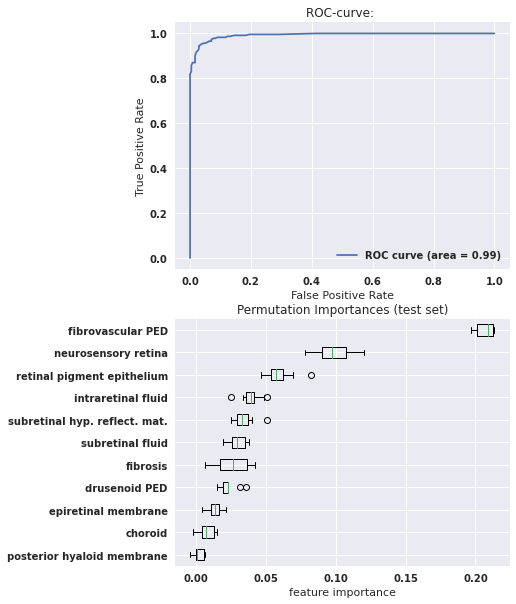

In [588]:
fpr, tpr, thresh, feature_importance_result, fetures_sorted_idx, model = predict_binary_class(adata, 
                                                                               features=["NORMAL", "CNV"])


import matplotlib as mpl
plt.rcParams.update({'font.size': 22})

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,10))

ax1 = roc_plot(ax1, fpr, tpr)
ax2 = feature_importance_plot(ax2, feature_importance_result, fetures_sorted_idx)

# Correct and incorrect predictions

Trying to set attribute `.obs` of view, copying.


RF train accuracy: 0.911
RF test accuracy: 0.913


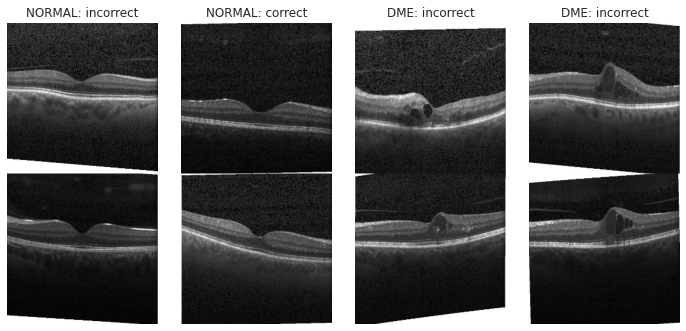

In [614]:
def plot_image_canvas(ax, canvas_image, title):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    canvas_image : full image

    Returns
    -------
    out : list
        list of artists added
    """
    ax.imshow(canvas_image)
    ax.axis("off")
    
    ax.set_title(title)
    return ax
    
    
def plot_correct_incorrect_exmaples(data_object, features):
    data_copy = deepcopy(data_object)

    available_features = data_copy.obs.obs_cls.unique()

    allowed_feature = [feature for feature in features if feature in available_features]
    for f in allowed_feature:
        assert f, f"invalid feature, feature must be in {available_features}"

    # extract columns belong to feature
    feature_f = data_copy.obs.obs_cls.isin(features)

    # annotate all other to not feature class
    data_copy = data_copy[feature_f]
    X_train = data_copy.X[data_copy.obs.split == "train"]
    y_train = data_copy.obs.obs_cls[data_copy.obs.split == "train"]
    X_test = data_copy.X[data_copy.obs.split == "test"]
    y_test = data_copy.obs.obs_cls[data_copy.obs.split == "test"]

    rf = Pipeline([('classifier', RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42))])

    rf.fit(X_train, y_train)
    
    print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
    print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

    y_predictions = rf.predict(X_test)

    n_samples = 2

    data_copy_test = data_copy[data_copy.obs.split == "test"]

    correct = np.where(y_test == y_predictions)

    data_copy_test.obs["correct_prediction"] = "incorrect"

    data_copy_test.obs["correct_prediction"][correct[0]] = "correct"

    viz_samples_dict = {features[0]: {}, features[1]: {}}

    for feature in features:
        viz_samples_dict[feature]["correct"] = []
        viz_samples_dict[feature]["incorrect"] = []

        for correct in ["correct", "incorrect"]:
            c_f = data_copy_test.obs.correct_prediction == correct
            f_f = data_copy_test.obs.obs_cls == feature

            dc_filtered = data_copy_test.obs[c_f & f_f]

            viz_samples_dict[feature][correct].extend(dc_filtered.img_path.sample(n_samples).tolist())

    icn_image_list = [cv2.resize(cv2.imread(path), (256,256)) for path in viz_samples_dict["NORMAL"]["incorrect"]]
    cn_image_list = [cv2.resize(cv2.imread(path), (256,256)) for path in viz_samples_dict["NORMAL"]["correct"]]
    if_mage_list = [cv2.resize(cv2.imread(path), (256,256)) for path in viz_samples_dict[features[1]]["incorrect"]]
    f_image_list = [cv2.resize(cv2.imread(path), (256,256)) for path in viz_samples_dict[features[1]]["correct"]]

    canvas = np.concatenate([np.concatenate(icn_image_list), 
                    np.concatenate(cn_image_list), 
                    np.concatenate(if_mage_list), 
                    np.concatenate(f_image_list)], axis=1)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(10,10))

    plot_image_canvas(ax1, canvas_image=np.concatenate(icn_image_list), title= "NORMAL: incorrect")
    plot_image_canvas(ax2, canvas_image=np.concatenate(cn_image_list), title= "NORMAL: correct")
    plot_image_canvas(ax3, canvas_image=np.concatenate(if_mage_list), title= f"{features[1]}: incorrect")
    plot_image_canvas(ax4, canvas_image=np.concatenate(f_image_list), title= f"{features[1]}: incorrect")

    plt.tight_layout()
    return rf
    
features=["NORMAL", "DME"]
rf = plot_correct_incorrect_exmaples(adata, features)

## Fit estimators

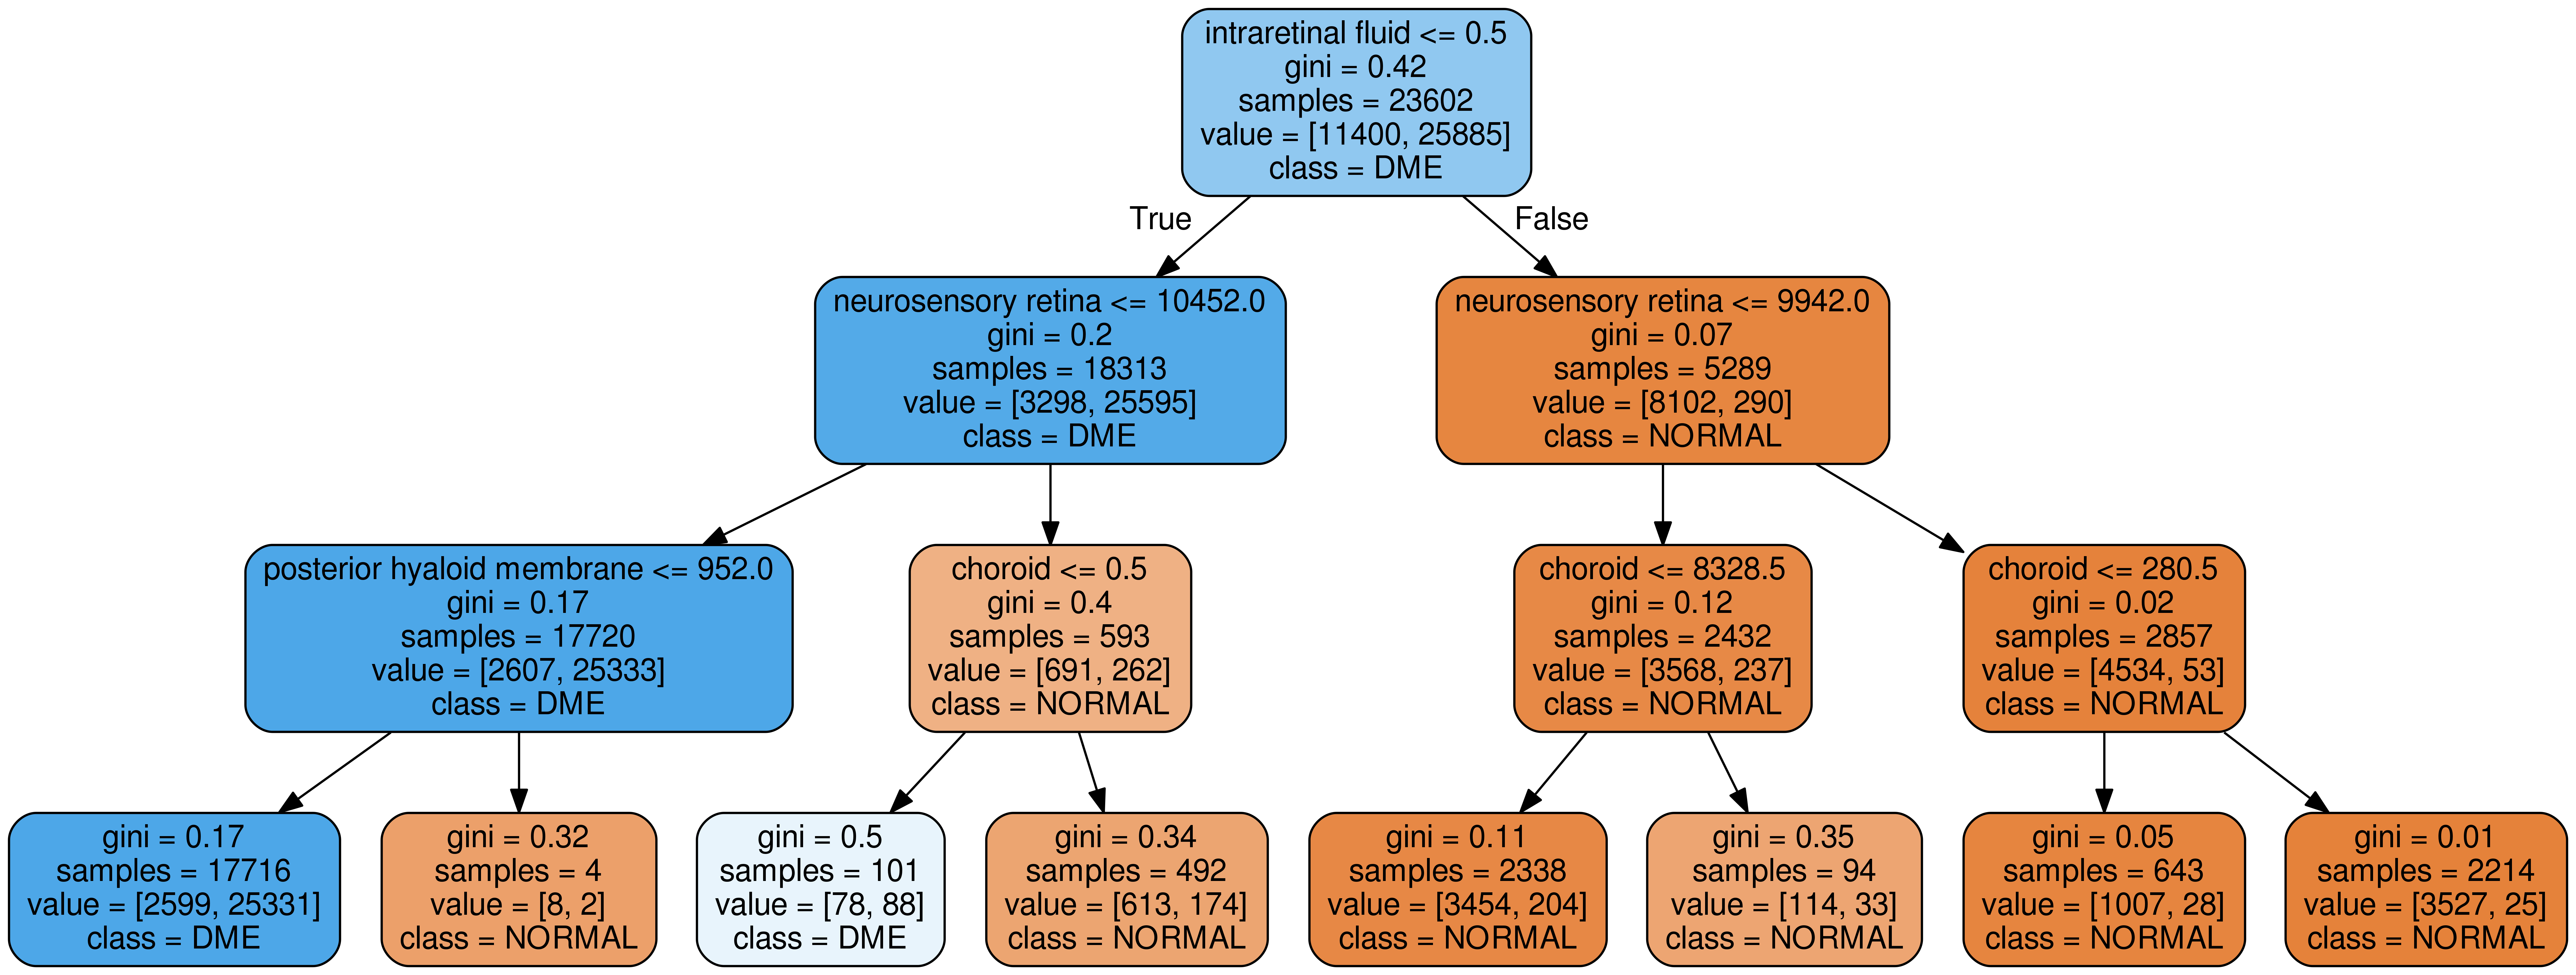

In [615]:
# Extract single tree
estimator = rf[0].estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = adata.var.var_name.tolist(),
                class_names = features,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [580]:
record = '/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test/DRUSEN/DRUSEN-1793499-1.jpeg'
adata[adata.obs.img_path == record].X

ArrayView([[  14., 5055.,    0.,    0.,    0.,  782.,   11.,  109.,
               0., 2335.,    0.]], dtype=float32)

In [581]:
record = '/home/olle/PycharmProjects/LODE/workspace/cell_oct_data/test/DRUSEN/DRUSEN-2951435-1.jpeg'
adata[adata.obs.img_path == record].X

ArrayView([[ 194., 9494.,    0.,    0.,    0.,  888.,    0.,    0.,
               0., 4490.,    0.]], dtype=float32)

In [578]:
adata[adata.obs.img_path == record].var

,var_name
1,epiretinal membrane
2,neurosensory retina
3,intraretinal fluid
4,subretinal fluid
5,subretinal hyp. reflect. mat.
6,retinal pigment epithelium
7,fibrovascular PED
8,drusenoid PED
9,posterior hyaloid membrane
10,choroid


## Permutation test for feature importance

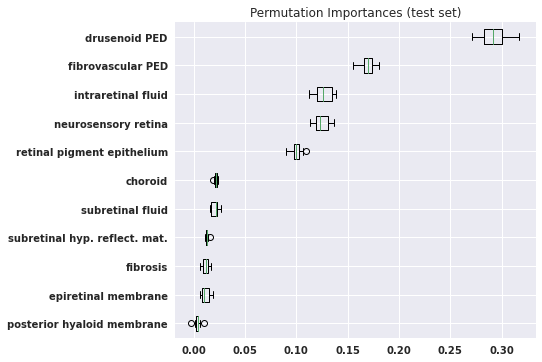

In [302]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=adata.var.var_name[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Controlling for Multicorrelation

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


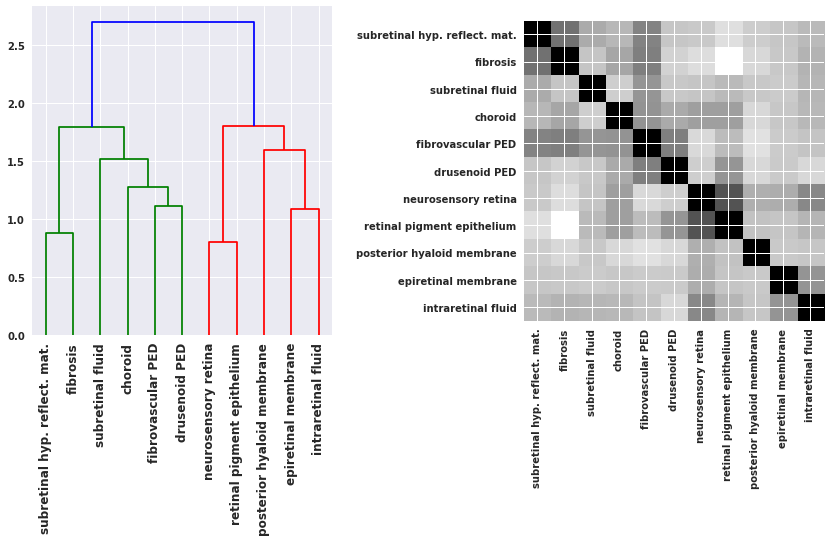

In [303]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(adata.X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=adata.var.var_name.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [304]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.88


In [305]:
cluster_ids
[v for v in cluster_id_to_feature_ids.values()]

[[0], [1, 5], [2], [3], [4, 10], [6], [7], [8], [9]]

In [306]:
sorted_idx

array([ 8,  0, 10,  4,  3,  9,  5,  1,  2,  6,  7])

In [307]:
adata.var.var_name

1               epiretinal membrane
2               neurosensory retina
3                intraretinal fluid
4                  subretinal fluid
5     subretinal hyp. reflect. mat.
6        retinal pigment epithelium
7                 fibrovascular PED
8                     drusenoid PED
9        posterior hyaloid membrane
10                          choroid
11                         fibrosis
Name: var_name, dtype: object

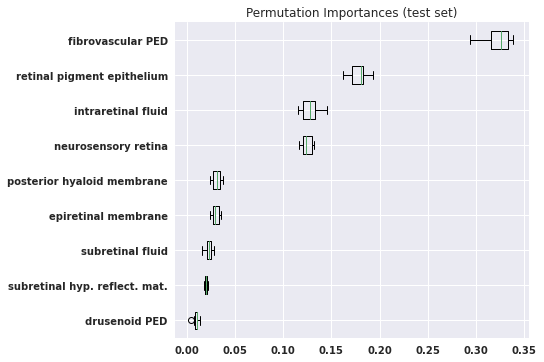

In [308]:
result = permutation_importance(clf_sel, X_test_sel, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=adata.var.var_name[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()